In [9]:
!nvidia-smi

Tue Apr 25 12:19:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    12W / 240W |    349MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py

#%tensorflow_version 2.x
#%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Layer
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Reshape, ConvLSTM2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.activations import relu

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, activations
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ppi_irv2

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [2]:
base_path = '/home/cvpr/Documents/Siladittya/Dataset/'

In [3]:
mrnet_path = base_path+'MRNet-v1.0/'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['valid-meniscus.csv', 'valid-abnormal.csv', 'train-abnormal.csv', 'valid-acl.csv', 'train-acl.csv', 'valid', 'train', '.DS_Store', 'train-meniscus.csv']

Label Files...
['valid-meniscus.csv', 'valid-abnormal.csv', 'train-abnormal.csv', 'valid-acl.csv', 'train-acl.csv', 'train-meniscus.csv']


In [10]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'train-meniscus.csv',header=None)
#trmen.head()

trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [11]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'valid-meniscus.csv',header=None)

valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


In [12]:
tr_filenames_df = pd.DataFrame(columns=['filename'])
tr_filenames_df['filename'] = os.listdir(mrnet_path+'train/axial')
tr_filenames_df['patient_id'] = tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
tr_filenames_df = tr_filenames_df[list(('patient_id','filename'))]
tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

tr_filenames_df

,patient_id,filename
0,0,0000.npy
1,1,0001.npy
2,2,0002.npy
3,3,0003.npy
4,4,0004.npy
...,...,...
1125,1125,1125.npy
1126,1126,1126.npy
1127,1127,1127.npy
1128,1128,1128.npy


In [13]:
val_filenames_df = pd.DataFrame(columns=['filename'])
val_filenames_df['filename'] = os.listdir(mrnet_path+'valid/axial')
val_filenames_df['patient_id'] = val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
val_filenames_df = val_filenames_df[list(('patient_id','filename'))]
val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

val_filenames_df

,patient_id,filename
0,1130,1130.npy
1,1131,1131.npy
2,1132,1132.npy
3,1133,1133.npy
4,1134,1134.npy
...,...,...
115,1245,1245.npy
116,1246,1246.npy
117,1247,1247.npy
118,1248,1248.npy


In [16]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'train'
valid_dir = mrnet_path+'valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

# access_token = '1094213176:AAFPM2lzoWH_fvQXgDjUtluJCctamMp5Ax0'
NUM_FRAMES = 8
batch_size = 1 #32
NUM_CLASSES = 3
NUM_PATCHES = 9

In [17]:
model_path = '/home/cvpr/Documents/Siladittya/tai/saved_models/'

In [18]:
def conv_block(inp):
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    #,kernel_regularizer =regularizers.l2(0.00001)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    return out

def dim_red_block(inp,numfilts):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 2, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out2 = AveragePooling2D(pool_size=(2,2),strides=2)(inp)
    
    out2 = Conv2D(filters = numfilts, kernel_size = 1, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    
    out = Concatenate()([out1,out2])
    
    return out

def skip_block(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts//2, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

def skip_block2(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

def rocket_model_branch(input_shape,num):
    branch_inp = Input(shape=input_shape)
    branch = conv_block(branch_inp)
    
    model = Model(inputs = branch_inp, outputs = branch, name = 'branch'+str(num))
    
    return model

def conv1x1_part(input_shape):

    conv1x1_inp = Input(shape=input_shape)
    
    model_stem = Conv2D(filters = 1024, kernel_size = 1, strides = 1, padding = 'same', activation = None, 
                        kernel_initializer = tf.keras.initializers.he_normal(seed=SEED),
                        kernel_regularizer =regularizers.l2(0.0001))(conv1x1_inp)
    model_stem = BatchNormalization()(model_stem)
    model_stem = Activation('relu')(model_stem)
    
    model = Model(inputs=conv1x1_inp,
                  outputs = model_stem, name = 'conv1x1_part')
    
    return model

def rocket_model_part2(input_shape):

    model_stem_inp = Input(shape=input_shape)
    
    model_stem = skip_block2(model_stem_inp,1024,scale=0.25)
    model_stem = dim_red_block(model_stem,1024)
    
    model = Model(inputs = model_stem_inp, outputs = model_stem, name = 'rocket_model_part2')
    
    return model

def rocket_model_part3(input_shape):

    model_stem_inp = Input(shape=input_shape)
    
    model_stem = skip_block2(model_stem_inp,2048,scale=0.25)
    model_stem = dim_red_block(model_stem,2048)
    
    model = Model(inputs = model_stem_inp, outputs = model_stem, name = 'rocket_model_part3')
    
    return model

In [19]:
print("Building Pretext model...")
SEED = 16
branch1 = rocket_model_branch((256,256,3),1)
branch2 = rocket_model_branch((256,256,3),2)
branch3 = rocket_model_branch((256,256,3),3)
branch4 = rocket_model_branch((256,256,3),4)
branch5 = rocket_model_branch((256,256,3),5)
branch6 = rocket_model_branch((256,256,3),6)
branch7 = rocket_model_branch((256,256,3),7)
branch8 = rocket_model_branch((256,256,3),8)
branch9 = rocket_model_branch((256,256,3),9)
conv1x1 = conv1x1_part((64,64,2304))
pretext_part2 = rocket_model_part2((64,64,1024))
pretext_part3 = rocket_model_part3((32,32,2048))

Building Pretext model...


In [20]:
def initialize(filename):

	branch1.load_weights(model_path + filename,by_name=True)
	branch2.load_weights(model_path + filename,by_name=True)
	branch3.load_weights(model_path + filename,by_name=True)
	branch4.load_weights(model_path + filename,by_name=True)
	branch5.load_weights(model_path + filename,by_name=True)
	branch6.load_weights(model_path + filename,by_name=True)
	branch7.load_weights(model_path + filename,by_name=True)
	branch8.load_weights(model_path + filename,by_name=True)
	branch9.load_weights(model_path + filename,by_name=True)
	conv1x1.load_weights(model_path + filename,by_name=True)
	pretext_part2.load_weights(model_path + filename,by_name=True)
	pretext_part3.load_weights(model_path + filename,by_name=True)

In [21]:
# pretext_part.load_weights(model_path + "pretext/sagittal_pretext_model.h5",by_name=True)
initialize("pretext/sagittal_pretext_model.h5")

In [57]:
class DSDataGen(Sequence):
    def __init__(self, phase, injury, mode, base_dir, labs_df, filenames_df, pretext_model, preprocess_input = None, 
                 batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir +phase
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.pretext_model = pretext_model
        self.MAX_FRAMES = num_frames #NUM_FRAMES
         
        self.mode = mode #['sagittal','coronal','axial']
        self.injury = injury

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug
        
        self.startind = 0
        self.endind = self.startind + self.batch_size
    
    def load_volume(self,mode,file_idx):
        filepath = self.ph_mode_dir+'/'+mode+'/'+self.filenames_df['filename'].iloc[file_idx]
        #print(self.filenames_df['filename'].iloc[file_idx])
        npy_file = np.load(filepath)
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        
        tot_frames = image_volume.shape[0]
        self.num_frames = np.min([tot_frames,self.MAX_FRAMES])
        
        ftnum = tot_frames//5
        #rnum = tot_frames - lnum
        fnum = self.num_frames//5
        
        frame_idxs = random.sample(list(range(ftnum)),fnum)+\
                     random.sample(list(range(ftnum,tot_frames-ftnum)),self.num_frames-2*fnum)+\
                     random.sample(list(range(tot_frames-ftnum,tot_frames)),fnum)
        
        frame_idxs = np.array(sorted(frame_idxs))
        #print(frame_idxs)
        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx,:,:])
            frame = np.expand_dims(frame,axis=2)
            frame = np.append(frame,np.append(frame,frame,axis=2),axis=2)
            
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return len(self.filenames_df)
    
    def __getitem__(self,idx):
        
        self.startind = idx*self.batch_size
        self.endind = self.startind + self.batch_size
        idx = idx #//8
        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))
        
        ds_batch_labs = self.mllabs[['abn','acl','men']].iloc[idx].values.reshape((1,-1)).astype(np.float32)
        
        #GET CLIP FRAMES
        batch_imgs = np.append(batch_imgs,self.get_frames(self.mode,idx),axis=0)

        sind = 0
        eind = 0
        tot_frames = batch_imgs.shape[0]

        #PREPROCESS FRAMES
        batch_imgs = self.preprocess_input(batch_imgs)
        
        b1out = branch1(batch_imgs)
        b2out = branch2(batch_imgs)
        b3out = branch3(batch_imgs)
        b4out = branch4(batch_imgs)
        b5out = branch5(batch_imgs)
        b6out = branch6(batch_imgs)
        b7out = branch7(batch_imgs)
        b8out = branch8(batch_imgs)
        b9out = branch9(batch_imgs)
        
        bouts = np.concatenate([b1out,b2out,b3out,b4out,b5out,b6out,b7out,b8out,b9out],axis=3)
        
        b1out,b2out,b3out,b4out,b5out,b6out,b7out,b8out,b9out = [None]*9
        
        bouts = conv1x1(bouts)
        
        bouts = pretext_part2(bouts)
        
        bouts = pretext_part3(bouts)
        
        bouts = np.expand_dims(bouts,axis=0)
        
        return batch_imgs, bouts, ds_batch_labs 
    
    def on_epoch_end(self):
        idx = np.random.permutation(self.filenames_df.index.values)
        self.mllabs = self.mllabs.reindex(idx)
        self.filenames_df = self.filenames_df.reindex(idx)
        self.mllabs = self.mllabs.reset_index(drop=True)
        self.filenames_df = self.filenames_df.reset_index(drop=True)
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-20,0,20])
        scale = np.random.choice([1,1.15])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-15,0,15])],
                                        [0,               scale,         np.random.choice([-15,0,15])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [23]:
inp = Input(shape = (None,16,16,4096)) #pretext_part.output

In [24]:
from tensorflow.keras.layers import Layer
class TemporalReshape(Layer):
    def call(self, inputs):
        #print(inputs.get_shape())
        nshape = (1,NUM_FRAMES) + inputs.shape[1:]
        return tf.reshape(inputs, nshape)
# out = TemporalReshape()(inp)

In [25]:
out = ConvLSTM2D(512,3,strides = (1,1), padding = 'valid',
                 data_format = 'channels_last', kernel_initializer = tf.keras.initializers.he_normal(seed=16),
                 return_sequences = True)(inp)
out = ConvLSTM2D(512,3,strides = (1,1), padding = 'valid',
                 data_format = 'channels_last', kernel_initializer = tf.keras.initializers.he_normal(seed=16),
                 return_sequences = True)(out)
out = out[:,-1,:,:,:]
out = GlobalAveragePooling2D()(out)

In [26]:
out = Dense(3,activation='sigmoid',kernel_initializer = tf.keras.initializers.he_normal(seed=16))(out)

In [27]:
dsmodel = Model(inp,out)

In [28]:
dsmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, 16, 16, 409 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 14, 14, 512) 84936704  
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 12, 12, 512) 18876416  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 12, 12, 512)]     0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 103,814,659
Trainable params: 103,814,659
Non-trainable params: 0
________________________________________

In [29]:
!nvidia-smi

Tue Apr 25 12:19:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P2    36W / 240W |   7537MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
dsmodel.load_weights(model_path + 'downstream/sagittal_downstream_model.h5',by_name = True)

In [58]:
vdg = DSDataGen('valid',None,'sagittal',mrnet_path, val_multilabel, val_filenames_df, None,
                preprocess_input = ppi_irv2, batch_size=1, num_frames = NUM_FRAMES,
                data_aug = False, num_classes=NUM_CLASSES)


In [59]:
a,b,c = vdg.__getitem__(110)

In [60]:
a.shape

(8, 256, 256, 3)

In [34]:
np.where(b==1)[1]

array([0, 2])

In [35]:
for l in dsmodel.layers:
    print(l.name)

input_13
conv_lst_m2d
conv_lst_m2d_1
tf_op_layer_strided_slice
global_average_pooling2d
dense


In [36]:
dsmodel.get_layer('conv_lst_m2d_1').output.shape

TensorShape([None, None, 12, 12, 512])

In [37]:
gradcam_save_path = '/home/cvpr/Documents/Siladittya/tai/gradcams'

In [85]:
def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function(image)
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)

    # print(grads_val.shape)
    # print(conv_output.shape)
    # print(image.shape)
    cam = np.array([]).reshape((0,W,H))
    for fr in range(image.shape[1]):
        conv_output_, grads_val_ = conv_output[0,fr, :,:,:], grads_val[0,fr, :, :, :]
        #print(conv_output.shape)
        weights = np.mean(grads_val_, axis=(0, 1))
        cam_ = np.dot(conv_output_, weights)
        # Process CAM
        cam_ = resize(cam_, (W, H),preserve_range=True)
        for i in range(cam_.shape[0]):
            for j in range(cam_.shape[1]):
                cam_[i,j] = np.maximum(cam_[i,j],0)
        # cam_ = np.maximum(cam_, 0)
        cam_ = (cam_ - cam_.min())/ (cam_.max()-cam_.min()+1e-6)
        cam = np.append(cam,cam_[None,:,:],axis=0)
    # print(cam.shape)
    return cam


def compute_gradcam(model, datagen, labels, plane,  selected_labels, num,df=None,
                    layer_name='bn'):
    patient_id = 1130 + num
    if not os.path.exists(os.path.join(gradcam_save_path, str(patient_id), plane)):
        os.makedirs(os.path.join(gradcam_save_path, str(patient_id), plane))
        
    batch_imgs, preprocessed_input, inp_labels = datagen.__getitem__(num) #(load_image(img, image_dir, df)
    print(inp_labels)
    # inp_labels = np.where(inp_labels==1)[1]
    # print(inp_labels, inp_labels.shape)
    # input_array = [preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input]
    predictions = model.predict(preprocessed_input)#input_array)
    print(predictions, predictions.shape)
    class_labels = ['Abnormality','ACL Tear','Meniscus Tear']
    for i in range(3): # len(inp_labels)):
        print(f"Generating gradcam for class {class_labels[i]}")
        if not os.path.exists(gradcam_save_path+'/'+str(patient_id)+'/'+plane+'/'+class_labels[i]):
            os.makedirs(gradcam_save_path+'/'+str(patient_id)+'/'+plane+'/'+class_labels[i])
        
        input_arr = []
        # k = 1
        gradcam = grad_cam(model, preprocessed_input, i, layer_name)
        gradcam = np.nan_to_num(gradcam)
        # print(gradcam.shape)
        #gradcam = resize(gradcam,(256,256),preserve_range = True)
        for j in range(gradcam.shape[0]):
            plt.figure(figsize=(30,30))
            # plt.subplot(3,1,k)
            plt.title("Heatmap for "+ class_labels[i]+'|| p = '+str(predictions[0][i])[:5], fontsize = 64)
            plt.axis('off')
            plt.imshow((batch_imgs[0]+1)/2,cmap='gray')
            plt.imshow(gradcam[i], cmap='jet',alpha=0.4)
            plt.savefig(gradcam_save_path+'/'+str(patient_id)+'/'+plane+'/'+class_labels[i]+'/'+str(j+1)+'.png')
            plt.close()
        # k+=1


[[0. 0. 0.]]
[[0.10474227 0.03860415 0.05993646]] (1, 3)
Generating gradcam for class Abnormality
Generating gradcam for class ACL Tear
Generating gradcam for class Meniscus Tear


KeyboardInterrupt: 

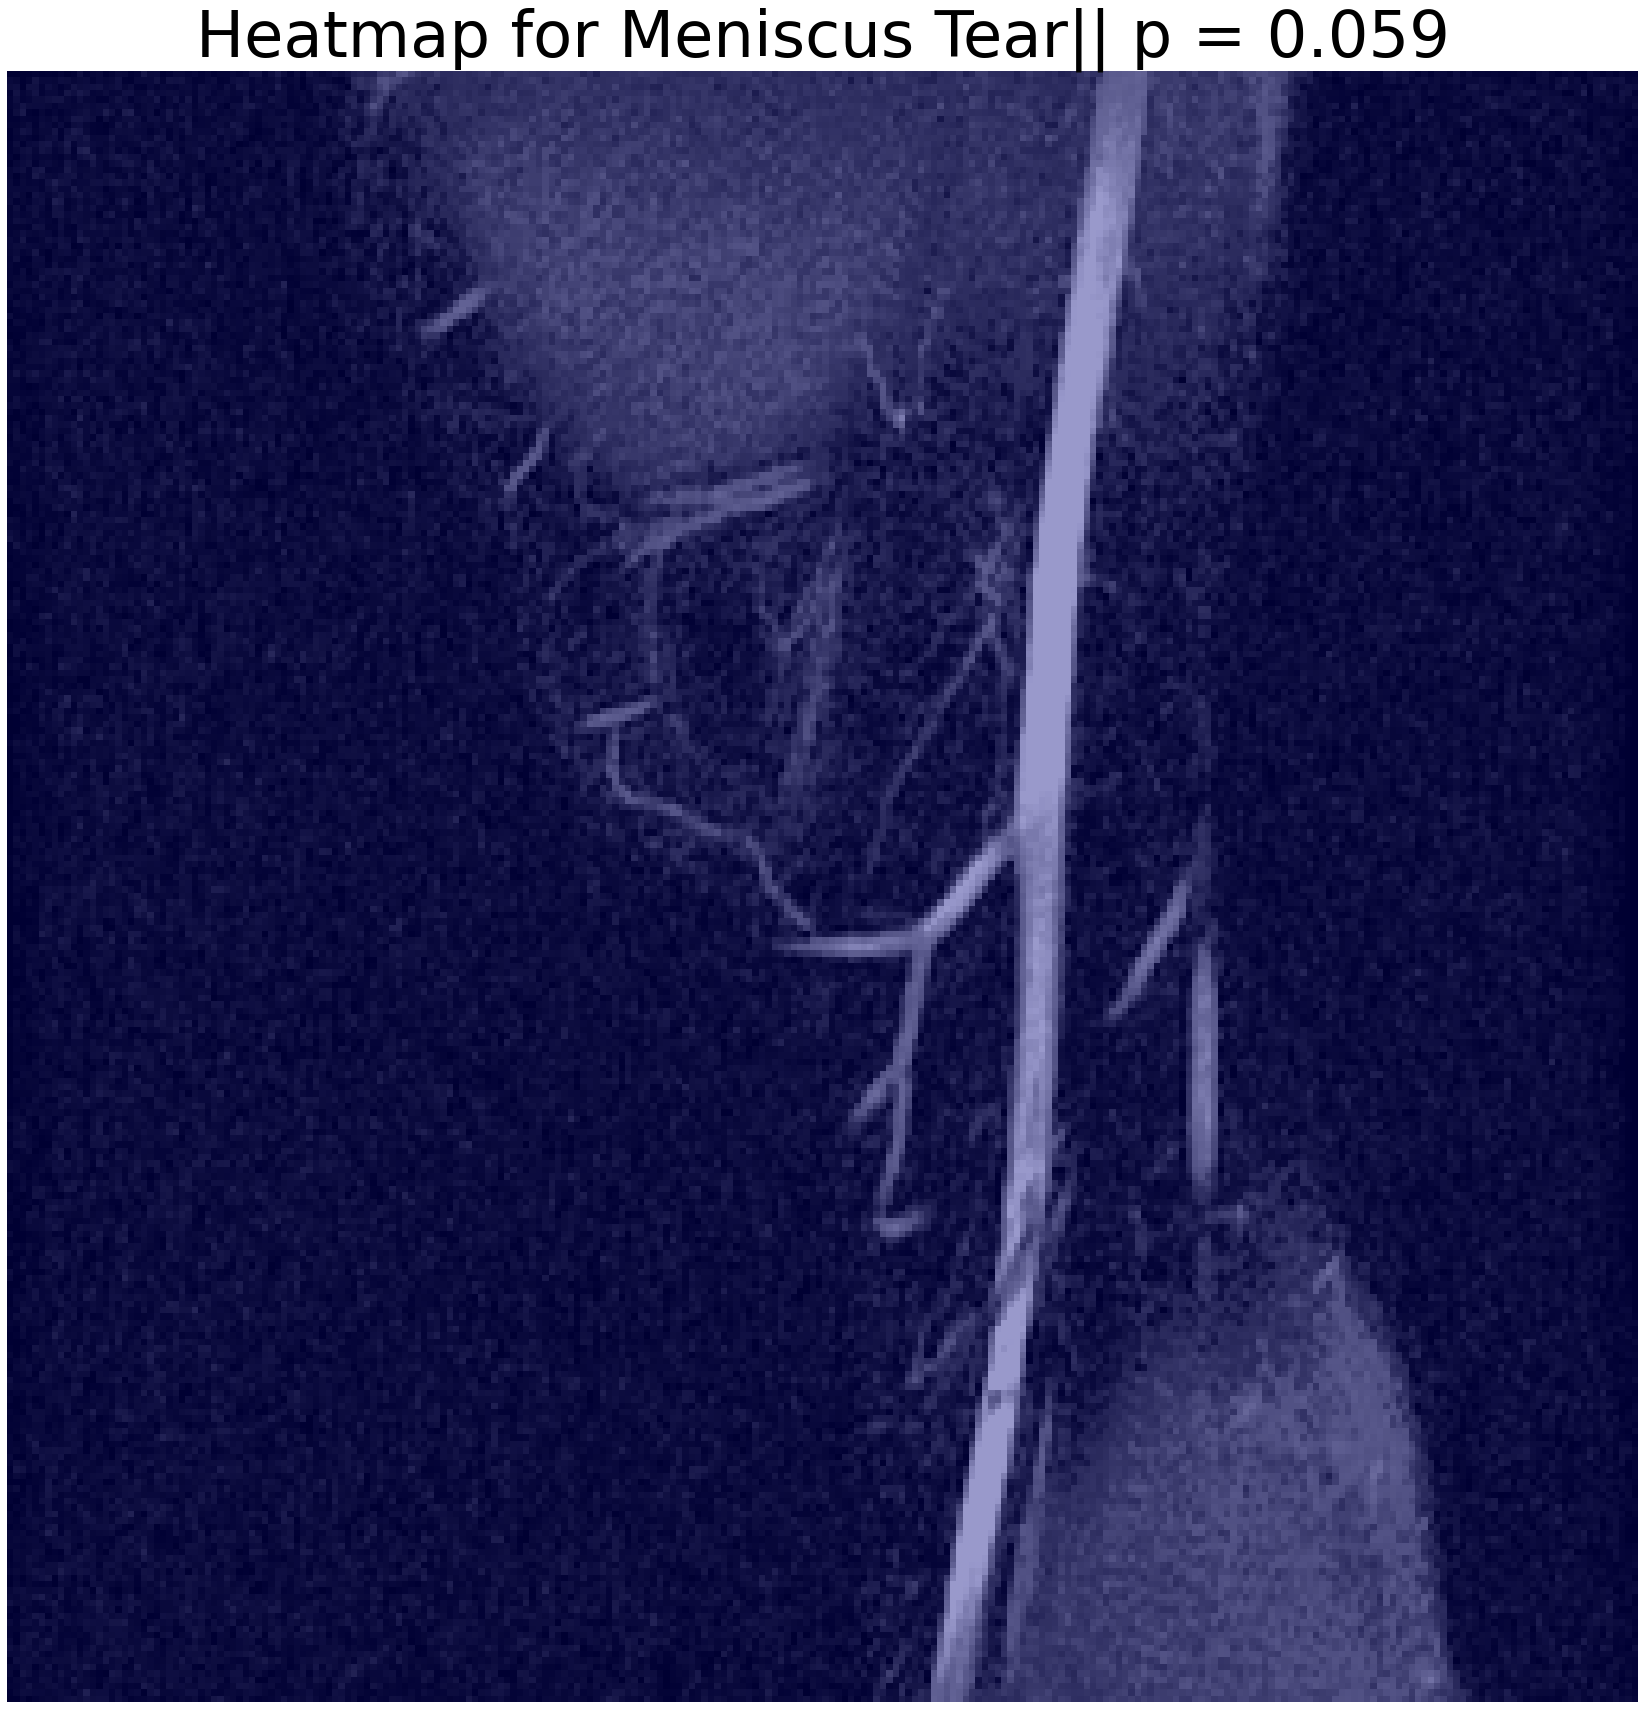

In [86]:
for i in range(120):
    compute_gradcam(dsmodel, vdg, list(range(3)), 'sagittal', list(range(3)), i, layer_name='conv_lst_m2d_1')